# Introduction to Time Series Analysis

**Time series analysis** is a statistical technique and a branch of data analysis that focuses on studying and modeling data points collected, recorded, or observed over a sequential and equally spaced time interval. Time series data represents **observations of a variable or phenomenon at different points in time**, and the goal of time series analysis is to extract meaningful insights, patterns, and predictions from this data.

## Importing Libraries

The code begins by importing necessary Python libraries for data analysis, visualization, time series modeling, and performance evaluation. The libraries included are:


1.   **Pandas** - Pandas is a powerful data manipulation and analysis library for Python. It provides data structures and functions for working with structured data, such as tables or spreadsheets.
2.   **Numpy** - NumPy (Numerical Python) is a fundamental library for numerical and mathematical operations in Python. It provides support for arrays and matrices, essential for scientific and numerical computations.
3.   **Matplotlib** - Matplotlib is a data visualization library for creating static, animated, or interactive plots and charts. It is widely used for creating graphical representations of data.
4.   **Warnings** - The warnings module is a built-in Python library for controlling the issuance of warning messages in your code. It allows you to suppress or handle warnings, making your code cleaner and more robust.
5.   **Statsmodels** - Statsmodels is a Python library for estimating and interpreting various statistical models. It is particularly useful for time series analysis, regression analysis, and hypothesis testing.
6.   **Scikit-learn** - Scikit-Learn is a machine learning library that provides a wide range of machine learning algorithms and tools for data mining and data analysis. It is designed for easy integration into data analysis workflows.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

The dataset is loaded from a CSV file ("train.csv") into a Pandas DataFrame. The initial exploration includes displaying the first few rows and summary statistics of the dataset.

The code converts the "Order Date" column to datetime format, sorts the DataFrame by date, and then aggregates sales data into a time series using the groupby function.

In [3]:
df = pd.read_csv("train.csv")

print(df.head())
print(df.describe())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Exclude sales of last 7 days for testing purpose later
end_date = df['Order Date'].max()
start_date = end_date - timedelta(days=7)

filtered_df = df[df['Order Date'] < start_date]
filtered_df = filtered_df.sort_values('Order Date')

ori_sales = df.groupby('Order Date')['Sales'].sum()
sales_time_series = filtered_df.groupby('Order Date')['Sales'].sum()

## Exploratory Data Analysis (EDA)

**Exploratory Data Analysis (EDA)** is a systematic and critical process of analyzing, summarizing, and visualizing data to understand its key characteristics, uncover patterns, identify anomalies, and generate hypotheses. EDA is typically the initial phase of data analysis, and it plays a fundamental role in the data science and decision-making process. Advanced techniques that involved in EDA phase are:

1.   **Rolling Statistics for Seasonality and Trends** - The **rolling mean** (also known as a moving average) is calculated to smooth out short-term fluctuations or noise in time series data. The **rolling standard deviation** measures the volatility or variability of data points within a moving window. It is used to identify periods of high or low volatility.

2.   **Autocorrelation (ACF)** - Autocorrelation measures the correlation between a time series and its lagged values. It reveals how current data points depend on previous ones.
3.   **Partial Autocorrelation (PACF)** - Partial autocorrelation, in contrast to ACF, measures the direct correlation between a time series and its lagged values while accounting for the influence of intermediate lags.



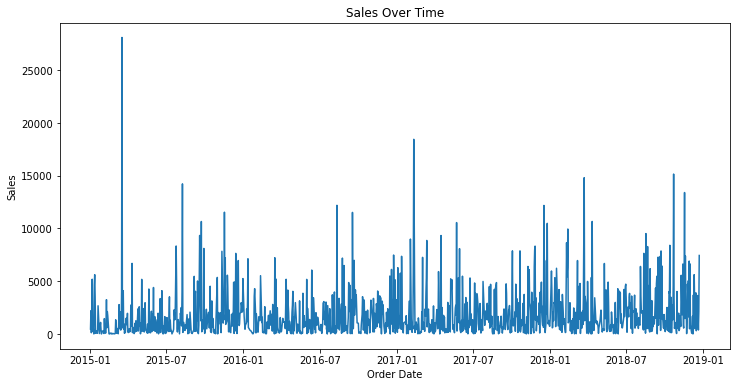

In [5]:
# EDA
plt.figure(figsize=(12,6))
plt.plot(sales_time_series)
plt.title('Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.show()

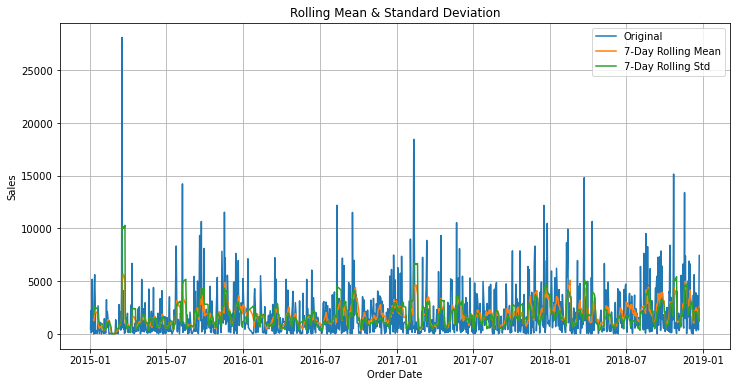

In [6]:
# Rolling Statistics for Seasonality and Trends
rolling_mean = sales_time_series.rolling(window=7).mean()  # 7-day rolling mean for weekly seasonality
rolling_std = sales_time_series.rolling(window=7).std()    # 7-day rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(sales_time_series, label='Original')
plt.plot(rolling_mean, label='7-Day Rolling Mean')
plt.plot(rolling_std, label='7-Day Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)

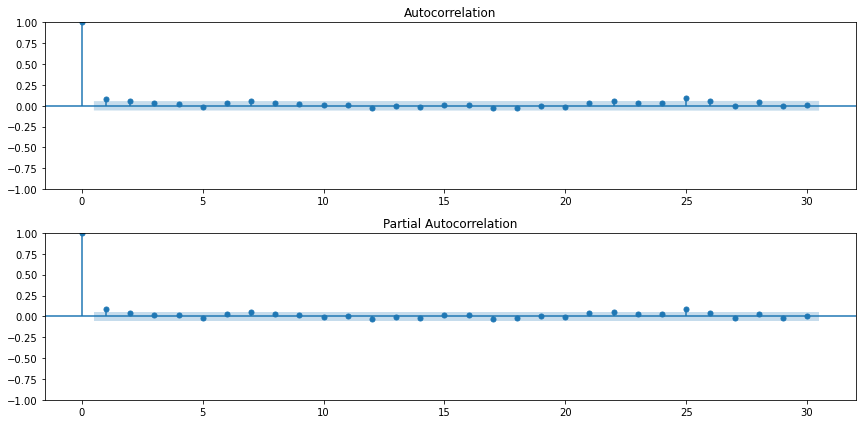

In [7]:
# ACF and PACF Plots for Autocorrelation
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_time_series, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(sales_time_series, lags=30, ax=plt.gca())
plt.tight_layout()

In [8]:
# Define a date range for the next 7 days
last_date = sales_time_series.index.max()
forecast_start_date = last_date + timedelta(days=1)
forecast_end_date = last_date + timedelta(days=7)
date_range = pd.date_range(forecast_start_date, forecast_end_date)

## Performance Metrics Calculation

**Mean Absolute Error (MAE)** is a metric used in regression analysis to measure the average absolute difference between the predicted values and the actual values. It provides a straightforward and easily interpretable measure of the accuracy of a predictive model. In professional contexts, MAE is often preferred when the emphasis is on the magnitude of errors without considering their direction. A lower MAE indicates better predictive performance, as it reflects a smaller average absolute deviation between predicted and actual values.

**Mean Squared Error (MSE)** is a widely used metric in regression analysis that measures the average of the squared differences between predicted and actual values. Unlike MAE, MSE gives more weight to larger errors, making it sensitive to outliers. In professional settings, MSE is suitable when there's a need to penalize larger errors more significantly. A lower MSE indicates better model performance, as it reflects a smaller average squared deviation between predicted and actual values. However, MSE is sensitive to outliers and may be influenced by extreme values in the dataset.

In [9]:
# Fit the Holt-Winters Exponential Smoothing model
model = ExponentialSmoothing(sales_time_series, trend='add', seasonal='add', seasonal_periods=7)
model_fit = model.fit(optimized=True)

In [10]:
# Forecast sales for the next 7 days
forecasted_sales = model_fit.forecast(steps=7)
forecast_df = pd.DataFrame({'Date': date_range, 'Forecasted Sales': forecasted_sales})
print(forecast_df)

           Date  Forecasted Sales
1222 2018-12-23       2539.787972
1223 2018-12-24       2984.549819
1224 2018-12-25       2516.118521
1225 2018-12-26       2740.784496
1226 2018-12-27       2350.517093
1227 2018-12-28       2783.973944
1228 2018-12-29       2632.565189


## Cross-Validation Using TimeSeriesSplit

**Cross-Validation with TimeSeriesSplit** is employed to assess the model's performance. The time series is divided into training and validation subsets to simulate forecasting and validation. For each fold, the Holt-Winters model is fit to the training data, and forecasts are generated for the validation set. Mean Absolute Error (MAE) and Mean Squared Error (MSE) are calculated for each fold.

In [11]:
mae = mean_absolute_error(ori_sales.iloc[forecast_df.index.min():forecast_df.index.max()], forecasted_sales.iloc[0:6])
mse = mean_squared_error(ori_sales.iloc[forecast_df.index.min():forecast_df.index.max()], forecasted_sales.iloc[0:6])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 1545.00
Mean Squared Error (MSE): 3443813.97
